# Histogram-Based Outlier Search

1. For each single feature (dimension), an univariate histogram is constructed first
    - If the feature comprises of categorical data, simple counting of the values of each category is performed and the relative frequency (height of the histogram) is computed.
    - For numerical features, two different methods can be used:
        1. _**Static bin-width histograms**_....
        the standard histogram building technique using k equal width bins over the value range. The frequency (relative amount) of samples falling into each bin is used as an estimate of the density (height of the bins)
        2. _**Dynamic bin-width histograms**_...values are sorted frst and then a fixed amount of N/k successive values are grouped into a single bin where N is the number of total instances and k the number of bins. Since the area of a bin in a histogram represents the number of observations, it is the same for all bins in our case. Because the width of the bin is defned by the first and the last value and the area is the same for all bins, the height of each individual bin can be computed. This means that bins covering a larger interval of the value range have less height and represent that way a lower density. However, there is one exception: Under certain circumstances, more than k data instances might have exactly the same value, for example if the feature is an integer and a long-tail distribution has to be estimated. In this case, our algorithm must allow to have more than N/k values in the same bin. Of course, the area of these larger bins will grow appropriately.
2. Now, for each dimension d, an individual histogram has been computed (regardless if categorical, fixed-width or dynamic-width), where the height of each single bin represents a density estimation. The histograms are then normalized such that the maximum height is 1.0. This ensures an equal weight of each feature to the outlier score.
3. height is 1.0. This ensures an equal weight of each feature to the outlier score. Finally, the HBOS of every instance p is calculated using the corresponding height of the bins where the instance is located:
    - <img


# Chaliye Shuru Kartey Hai

## Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from pyod.models.knn import KNN
from pyod.models.hbos import HBOS
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [3]:
def get_excel_columns(n_cols):
    col_list = []
    n = n_cols
    alpha_list = [chr(c) for c in range(ord('A'), ord('Z') + 1)]
    alpha_list.insert(0,'dummy')
    for i in range(1,n+1):
        col_i = ""
        index_list=[]
        p=[]
        while i>26:
            k = i%26
            i = i//26
            if k==0:
                index_list.append(26)
                i = i-1
            else:
                index_list.append(k)
        index_list.append(int(i))
        index_list.reverse()
        for i in index_list:
            p.append(alpha_list[i])
            col_i = "".join(p)
        col_list.append(col_i)
    return col_list

In [4]:
df = pd.read_csv("shuttle.csv", header = None)
df.columns = get_excel_columns(len(df.columns))
print(df.shape)
df.head()

(46464, 10)


,A,B,C,D,E,F,G,H,I,J
0,108.0,3.0,109.0,0.0,72.0,7.0,1.0,36.0,36.0,o
1,81.0,0.0,84.0,0.0,-14.0,-2.0,4.0,100.0,96.0,o
2,81.0,0.0,84.0,0.0,-20.0,16.0,4.0,105.0,102.0,o
3,76.0,-1.0,81.0,0.0,-42.0,-3.0,5.0,125.0,120.0,o
4,105.0,0.0,107.0,2.0,70.0,0.0,1.0,37.0,36.0,o


## Train-Test Split

In [5]:
X = df[get_excel_columns(len(df.columns) - 1)].values.astype(float)
X[0:5]

array([[108.,   3., 109.,   0.,  72.,   7.,   1.,  36.,  36.],
       [ 81.,   0.,  84.,   0., -14.,  -2.,   4., 100.,  96.],
       [ 81.,   0.,  84.,   0., -20.,  16.,   4., 105., 102.],
       [ 76.,  -1.,  81.,   0., -42.,  -3.,   5., 125., 120.],
       [105.,   0., 107.,   2.,  70.,   0.,   1.,  37.,  36.]])

In [6]:
scaler = StandardScaler()
X = scaler.fit(X).transform(X.astype(float))
X[0:5]

array([[ 7.22292697e+00,  8.39601067e-02,  2.76780064e+00,
        -7.48433629e-03,  2.09700256e+00,  2.65343969e-02,
        -3.56177703e+00, -5.97012096e-01,  1.97925322e+00],
       [ 4.13837948e+00,  1.61137132e-02, -9.55332010e-02,
        -7.48433629e-03, -3.31100839e+00, -2.41651309e-02,
        -3.28828740e+00,  3.15615103e+00,  5.97772949e+00],
       [ 4.13837948e+00,  1.61137132e-02, -9.55332010e-02,
        -7.48433629e-03, -3.68831148e+00,  7.72339247e-02,
        -3.28828740e+00,  3.44936690e+00,  6.37757712e+00],
       [ 3.56716698e+00, -6.50175136e-03, -4.39133262e-01,
        -7.48433629e-03, -5.07175614e+00, -2.97984118e-02,
        -3.19712419e+00,  4.62223037e+00,  7.57712000e+00],
       [ 6.88019947e+00,  1.61137132e-02,  2.53873393e+00,
         4.61108246e-02,  1.97123487e+00, -1.28985692e-02,
        -3.56177703e+00, -5.38368922e-01,  1.97925322e+00]])

In [7]:
y = df.iloc[:,-1]
len(y)

46464

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 4)
print("Train set : ", X_train.shape, y_train.shape)
print("Test set : ", X_test.shape, y_test.shape)

Train set :  (37171, 9) (37171,)
Test set :  (9293, 9) (9293,)


In [10]:
hbos = HBOS(n_bins = 20)
hbos.fit(X_train)

HBOS(alpha=0.1, contamination=0.1, n_bins=20, tol=0.5)

In [16]:
y_hat = hbos.predict(X_test)
y_hat

array([0, 0, 0, ..., 0, 0, 0])

In [13]:
y_test_array = y_test.to_numpy().astype(str)
y_test_array = np.where(y_test_array == 'n', 0, 1)
y_test_array

array([0, 0, 0, ..., 0, 0, 0])

In [18]:
n_errors = np.count_nonzero(y_test_array != y_hat)
n_errors

739

## Testing on different n_bins

In [19]:
error_list = []
accuracy_list = []

for i in range(1,51):
    h_baws = HBOS(n_bins = i)
    h_baws.fit(X_train)
    y_hat_i = h_baws.predict(X_test)
    n_errors_i = np.count_nonzero(y_hat_i != y_test_array)
    error_list.append(n_errors_i)
    accuracy_list.append((len(y_test)-n_errors_i)/len(y_test))

print(error_list)
print(accuracy_list)

[186, 22, 771, 732, 216, 775, 785, 689, 768, 698, 427, 714, 711, 746, 570, 717, 797, 807, 781, 739, 747, 772, 783, 758, 704, 780, 759, 703, 772, 707, 788, 772, 777, 770, 771, 772, 769, 779, 771, 744, 777, 761, 782, 789, 774, 766, 791, 762, 778, 801]
[0.9799849348972345, 0.997632626708275, 0.91703432691273, 0.9212310341116969, 0.9767566985903368, 0.9166038954051436, 0.9155278166361778, 0.9258581728182503, 0.9173571505434198, 0.924889701926181, 0.9540514365651566, 0.9231679758958355, 0.9234907995265254, 0.9197245238351447, 0.9386635101689443, 0.9228451522651459, 0.9142365221134187, 0.9131604433444528, 0.9159582481437641, 0.9204777789734209, 0.9196169159582481, 0.9169267190358334, 0.9157430323899709, 0.9184332293123857, 0.9242440546648014, 0.9160658560206607, 0.9183256214354891, 0.9243516625416981, 0.9169267190358334, 0.9239212310341117, 0.915204993005488, 0.9169267190358334, 0.9163886796513505, 0.9171419347896266, 0.91703432691273, 0.9169267190358334, 0.9172495426665231, 0.91617346389755

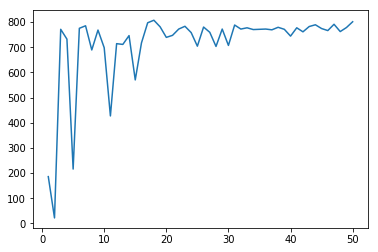

In [20]:
lol = sns.lineplot(range(1,51), error_list)

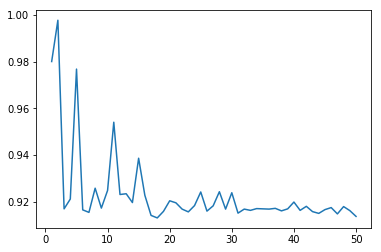

In [21]:
lmao = sns.lineplot(range(1,51), accuracy_list)